In [1]:
# Imports
from __future__ import print_function
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

DEVICE = torch.device("cpu")
BATCH_SIZE = 64
ANALYTICAL_KLD = True
EPOCHS = 50

## Paraphrase VAE

In this note we show a variant of VAE for paraphrase generation. Suppose given two samples of a digit in MNIST, we view the first sample as the 'original sentence' as well as the second one as the 'paraphrase sentence'. The figure below presents the diagram of our Paraphrase VAE which is a conditioned VAE. $x_1$, $x_2$ denote the 'original sentence' and the 'paraphrase sentence' respectively, and $z$ denotes the hidden code.

<img src="../images/paraphrase_diagram.png" width="400px"/>

The left hand side shows the recognition model (or the encoder) that model the posterior  probability as

$$q_\phi(z | x_2, x_1) \sim \mathcal{N}(\text{mlp}_\mu(x_2, x_1; \phi), \text{mlp}_\Sigma(x_2, x_1; \phi)) ,$$

while the right hand side shows the generative model (or the decoder) as $p_\theta(x_2 | z, x_1)$.



In [2]:
from models import ParaphraseVAE
model = ParaphraseVAE(784, 32, [256*2, 128*2, 100], [256*2]).to(DEVICE)
model

ParaphraseVAE(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=1568, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=100, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=100, out_features=32, bias=True)
      (log_var): Linear(in_features=100, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=816, out_features=512, bias=True)
    )
    (reconstruction): Linear(in_features=512, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
)

## Training
Recall the ELBO from the VAE formulation, we can construct a similar ELBO for our Paraphrase VAE as

$$
\mathcal{L} = \mathbb{E}_{q_\phi(z | x_2, x_1)}[ \log p_\theta(x_2|z, x_1) ] - \text{KL}[q_\phi(z | x_2, x_1) ~||~ p(z)],
$$

where the prior $p(z)$ is a standard Gaussian distribution.

In [3]:
# prepare dataset
import torch.utils.data
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

flatten = lambda x: transforms.ToTensor()(x).view(-1)

train_data = datasets.MNIST('../../data', train=True, download=True, transform=flatten)
valid_data = datasets.MNIST('../../data', train=False, download=True, transform=flatten)

train_label_indices = [(train_data.train_labels == label).nonzero().squeeze(1).numpy() 
                       for label in range(10)]
valid_label_indices = [(valid_data.test_labels == label).nonzero().squeeze(1).numpy() 
                       for label in range(10)]

kwargs = {'num_workers': 1, 'pin_memory': True} 
flatten = lambda x: transforms.ToTensor()(x).view(-1)
train_loader = [torch.utils.data.DataLoader(train_data, 
                                           batch_size=2, 
                                           shuffle=False, 
                                           sampler=SubsetRandomSampler(train_label_indices[label]),
                                           **kwargs)
               for label in range(10)]
valid_loader = [torch.utils.data.DataLoader(valid_data, 
                                           batch_size=2, 
                                           shuffle=False, 
                                           sampler=SubsetRandomSampler(valid_label_indices[label]),
                                           **kwargs)
               for label in range(10)]

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [11]:
INTERVAL = 10
VALID_INTERVAL = 100
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)
def train(epoch):
    model.train()
    for batch in range(1, len(train_data) / BATCH_SIZE + 1):
        train_loss = 0
        train_kl = 0
        x1, x2 = None, None
        for _ in range(BATCH_SIZE):
            label = np.random.randint(10)
            data, _ = next(iter(train_loader[label]))
            if x1 is None:
                x1, x2 = data[0, :].unsqueeze(0), data[1, :].unsqueeze(0)
            else:
                x1 = torch.cat((x1, data[0].unsqueeze(0)), dim=0)
                x2 = torch.cat((x2, data[1].unsqueeze(0)), dim=0)        
        x1, x2 = x1.to(DEVICE), x2.to(DEVICE)
        reconstruction = model(x1, x2)
        
        likelihood = -binary_cross_entropy(reconstruction, x2)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_kl += torch.sum(model.kl_divergence).item()
        train_loss += L.item() * BATCH_SIZE
    
        if batch % INTERVAL == 0:
            print("Epoch: {} {:5d}/{} | loss: {:5.2f} kl: {:5.2f}".
                  format(epoch,
                         batch * BATCH_SIZE,
                         len(train_data),
                         L.item(), 
                         torch.mean(model.kl_divergence).item()))
        if batch % VALID_INTERVAL == 0:
            test(epoch)
        
    if epoch % 1 == 0:
        print("Epoch: {} | loss: {:5.2f} kl: {:5.2f}".
              format(epoch, 
                     train_loss/len(train_data), 
                     train_kl/len(train_data)))
def test(epoch):
    model.eval()
    valid_loss = 0
    valid_kl = 0
    with torch.no_grad():
#         for batch in range(len(valid_data) / BATCH_SIZE):
        for batch in range(1):
            x1, x2 = None, None
            for _ in range(BATCH_SIZE):
                label = np.random.randint(10)
                data, _ = next(iter(valid_loader[label]))
                if x1 is None:
                    x1, x2 = data[0, :].unsqueeze(0), data[1, :].unsqueeze(0)
                else:
                    x1 = torch.cat((x1, data[0].unsqueeze(0)), dim=0)
                    x2 = torch.cat((x2, data[1].unsqueeze(0)), dim=0)        
            x1, x2 = x1.to(DEVICE), x2.to(DEVICE)
            reconstruction = model(x1, x2)

            likelihood = -binary_cross_entropy(reconstruction, x2)
            elbo = likelihood - model.kl_divergence
            valid_kl += torch.sum(model.kl_divergence).item()
            L = -torch.sum(elbo)
            valid_loss += L.item()
        print("Epoch: {} | test loss: {:5.2f} kl: {:5.2f}".
#               format(epoch, valid_loss/len(valid_data), valid_kl/len(valid_data)))
              format(epoch, valid_loss/BATCH_SIZE, valid_kl/BATCH_SIZE))

In [15]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

Epoch: 1   640/60000 | loss: 141.19 kl: 15.37
Epoch: 1  1280/60000 | loss: 134.45 kl: 14.24
Epoch: 1  1920/60000 | loss: 144.75 kl: 15.76
Epoch: 1  2560/60000 | loss: 142.41 kl: 16.54
Epoch: 1  3200/60000 | loss: 141.42 kl: 13.95
Epoch: 1  3840/60000 | loss: 136.76 kl: 14.25
Epoch: 1  4480/60000 | loss: 141.48 kl: 15.24
Epoch: 1  5120/60000 | loss: 141.58 kl: 16.04
Epoch: 1  5760/60000 | loss: 137.76 kl: 14.29
Epoch: 1  6400/60000 | loss: 141.02 kl: 14.88
Epoch: 1 | test loss: 140.19 kl: 16.28
Epoch: 1  7040/60000 | loss: 140.63 kl: 14.87
Epoch: 1  7680/60000 | loss: 143.96 kl: 17.29


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x11c740c10>> ignored


Epoch: 1  8320/60000 | loss: 140.19 kl: 12.76
Epoch: 1  8960/60000 | loss: 144.71 kl: 14.61
Epoch: 1  9600/60000 | loss: 136.18 kl: 15.61
Epoch: 1 10240/60000 | loss: 134.32 kl: 16.08
Epoch: 1 10880/60000 | loss: 138.06 kl: 15.21
Epoch: 1 11520/60000 | loss: 155.15 kl: 15.67
Epoch: 1 12160/60000 | loss: 140.71 kl: 15.55
Epoch: 1 12800/60000 | loss: 152.07 kl: 15.57
Epoch: 1 | test loss: 129.75 kl: 14.41
Epoch: 1 13440/60000 | loss: 137.39 kl: 15.38
Epoch: 1 14080/60000 | loss: 149.62 kl: 16.77
Epoch: 1 14720/60000 | loss: 143.24 kl: 15.44
Epoch: 1 15360/60000 | loss: 134.68 kl: 13.74
Epoch: 1 16000/60000 | loss: 148.21 kl: 16.03
Epoch: 1 16640/60000 | loss: 136.46 kl: 13.77
Epoch: 1 17280/60000 | loss: 140.50 kl: 15.18
Epoch: 1 17920/60000 | loss: 137.00 kl: 15.83
Epoch: 1 18560/60000 | loss: 143.71 kl: 12.12
Epoch: 1 19200/60000 | loss: 137.58 kl: 15.77
Epoch: 1 | test loss: 138.06 kl: 16.00
Epoch: 1 19840/60000 | loss: 140.41 kl: 15.25
Epoch: 1 20480/60000 | loss: 140.77 kl: 16.52
Ep

KeyboardInterrupt: 

## Paraphrase generation
To generate the 'paraphrase' sample of a given sample, we sample from the prior $p(z)$ and feed it to the generative model together with the given sample $x_1$.
The figures below show the generated 'paraphrase' samples. Note that samples in the first column are given $x_1$.

The first column is the given gold sample.


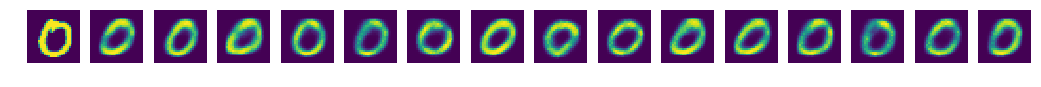

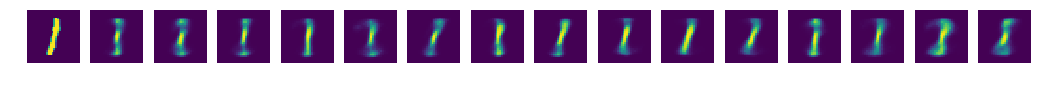

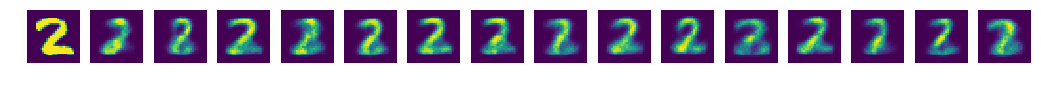

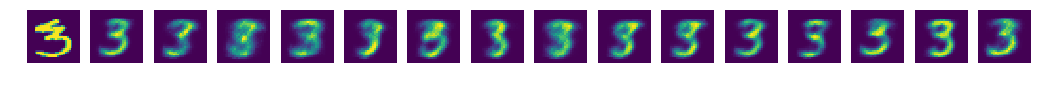

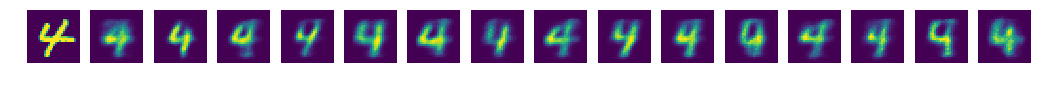

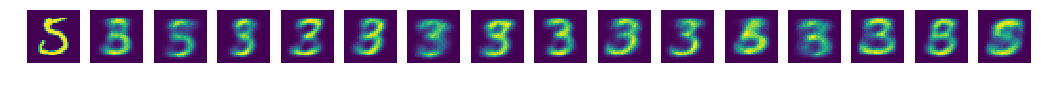

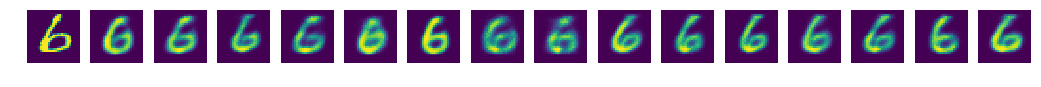

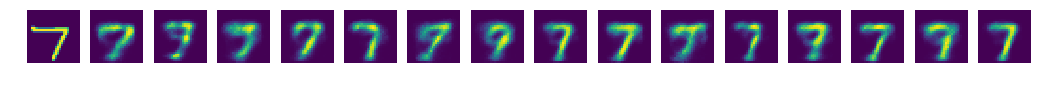

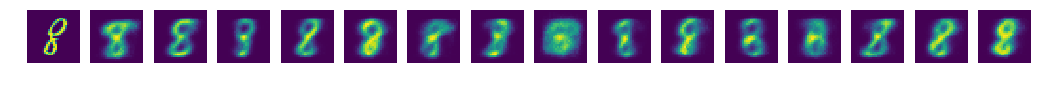

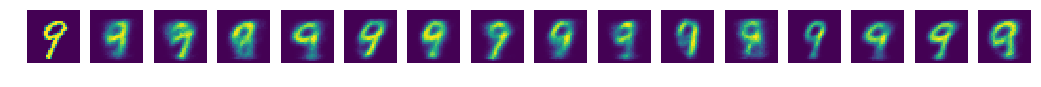

In [21]:
# generate 15 samples given a single digit
with torch.no_grad():
    print('The first column is the given gold sample.')
    for label in range(10):
        data, _ = next(iter(valid_loader[label]))
        x1 = data[0].unsqueeze(0).expand(15, 784).to(DEVICE)
        z = torch.randn(15, 32).to(DEVICE)
        samples = model.sample(z, x1)
        samples = torch.cat([data[0].view(1, 28, 28), samples.view(-1, 28, 28).cpu()])
        samples = samples.numpy()
        f, axarr = plt.subplots(1, 16, figsize=(18, 12))
        for i, ax in enumerate(axarr.flat):
            ax.imshow(samples[i])
            ax.axis("off")  